<a href="https://colab.research.google.com/github/mbruehl0828/workshop/blob/main/Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install -qqU crewai crewai_tools arxiv pypdf langchain_openai langchain langchain_community gradio faiss-cpu

Copy cell from this notebook to the next cell:
https://colab.research.google.com/drive/1PgQdfuN6hPw7pk4mJw_zJQsbbS6JNosU?usp=sharing

In [ ]:
# PASTE COPIED CELL HERE:



In [28]:

from typing import Type, List
from pydantic import BaseModel, Field
from crewai.tools import BaseTool
import arxiv
import datetime
import time
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.prompts.chat import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain import hub
from langchain_community.document_loaders import PyPDFLoader

from crewai import Agent, Task, Crew
import gradio as gr



## What is CrewAI?
CrewAI is a lean, lightning-fast Python framework built entirely from scratch—completely independent of LangChain or other agent frameworks.

CrewAI empowers developers with both high-level simplicity and precise low-level control, ideal for creating autonomous AI agents tailored to any scenario:

* CrewAI Crews: Optimize for autonomy and collaborative intelligence, enabling you to create AI teams where each agent has specific roles, tools, and goals.
* CrewAI Flows: Enable granular, event-driven control, single LLM calls for precise task orchestration and supports Crews natively.

https://docs.crewai.com/introduction

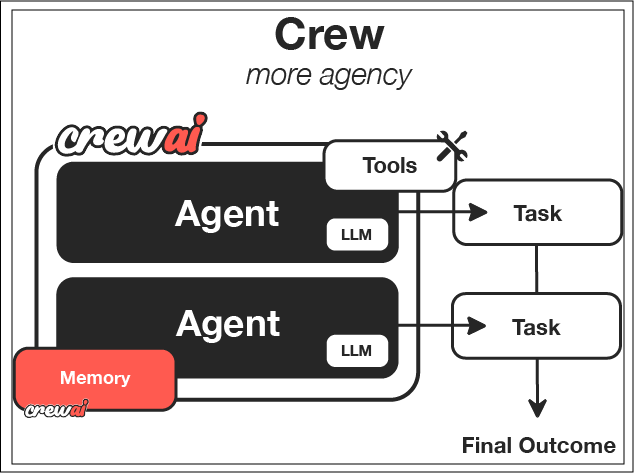

Component: Crew

Description: The top-level organization

Key Features:

* Manages AI agent teams
* Oversees workflows
* Ensures collaboration
* Delivers outcomes



---


Component: AI Agents

Description: Specialized team members

Key Features:

* Have specific roles (researcher, writer)
* Use designated tools
* Can delegate tasks
* Make autonomous decisions



---


Components: Process

Description: Workflow management system

* Defines collaboration patterns
* Controls task assignments
* Manages interactions
* Ensures efficient execution



---


Component: Tasks

Description:  Individual assignments

* Have clear objectives
* Use specific tools
* Feed into larger process
* Produce actionable results

In [4]:

"""
Main script for an AI research assistant that combines arXiv paper fetching, PDF processing, and a RAG-based chatbot.
The system uses CrewAI for multi-agent coordination and Gradio for the user interface.
"""

"""
ArXiv Paper Input Schema, Search and Download Tools
These classes provide functionality to search and download papers from arXiv.
"""

class FetchArxivPapersInput(BaseModel):
    """
    Input schema for FetchArxivPapersTool.
    Defines the expected input format for paper fetching operations.

    Attributes:
        target_date: Date for which to fetch papers
    """
    target_date: datetime.date = Field(..., description="Target date to fetch papers for.")

class FetchArxivPapersTool(BaseTool):
    """
    Tool for fetching arXiv papers from selected AI-related categories on a specific date.
    Implements paper searching and metadata collection functionality.
    """
    name: str = "fetch_arxiv_papers"
    description: str = "Fetches arXiv papers from selected categories submitted on the target date."
    args_schema: Type[BaseModel] = FetchArxivPapersInput

    def _run(self, target_date: datetime.date) -> List[dict]:
        """
        Executes the paper fetching operation for the specified date.
        Returns a list of paper metadata including titles, authors, summaries, and IDs.
        """
        # List of AI-related categories
        AI_CATEGORIES = ["cs.AI"]

        # Define the date range for the target date
        start_date = target_date.strftime('%Y%m%d%H%M')
        end_date = (target_date + datetime.timedelta(days=1)).strftime('%Y%m%d%H%M')

        # Initialize the arXiv client
        client = arxiv.Client(
            page_size=25,  # Fetch 25 results per page
            delay_seconds=4  # Delay between requests to respect rate limits
        )

        all_papers = []

        for category in AI_CATEGORIES:
            print(f"Fetching papers for category: {category}")

            search_query = f"cat:{category} AND submittedDate:[{start_date} TO {end_date}]"

            search = arxiv.Search(
                query=search_query,
                sort_by=arxiv.SortCriterion.SubmittedDate,
                max_results=25  # Fetch only 25 results
            )

            # Collect results for the category
            category_papers = []
            for result in client.results(search):
                category_papers.append({
                    'title': result.title,
                    'authors': [author.name for author in result.authors],
                    'summary': result.summary,
                    'id': result.get_short_id()
                })

                # Delay between requests to respect rate limits
                time.sleep(3)

            print(f"Fetched {len(category_papers)} papers from {category}")
            all_papers.extend(category_papers)

        return all_papers

In [5]:
class DownloadArxivPapersInput(BaseModel):
    """
    Input schema for DownloadArxivPapersTool.
    Defines the expected input format for paper downloading operations.

    Attributes:
        paper_id: Unique identifier for the arXiv paper
    """
    paper_id: str = Field(..., description="Paper id")

class DownloadArxivPapersTool(BaseTool):
    """
    Tool for downloading PDF files of arXiv papers using their IDs.
    Handles the actual paper download process.
    """
    name: str = "download_arxiv_papers"
    description: str = "Downloads arXiv paper from the paper id."
    args_schema: Type[BaseModel] = DownloadArxivPapersInput
    def _run(self, paper_id: str) -> str:

      paper = next(arxiv.Client().results(arxiv.Search(id_list=[paper_id])))
      paper.download_pdf()

      print(f"Download is complete for paper id: {paper_id}")
      return("Download is complete for paper id: ",paper_id)

In [7]:
# Instantiate each class to be used as a tool by Crew:
arxiv_search_tool = FetchArxivPapersTool()
arxiv_download_tool = DownloadArxivPapersTool()

### Agent definitions
These are the configurations of specialized AI agents with specific roles and responsibilities

In [8]:

# Agent 1: Arxiv Researcher
## This Agent is responsible for coordinating the paper search, and passing the papers off to the Downloader:
researcher = Agent(
    role = "Senior Researcher",
    goal = "Find 5 papers from the search results from arXiv on {date}."
            "Rank them randomly.",
    backstory = "You are a senior researcher with a deep understanding of all topics in AI and AI research."
                "You are able to identify interesting research papers based on the title and abstract.",
    verbose = True,
    max_iter = 20,  #Set to 2 tries for each of the 5 papers to avoid an endless loop (very important)
    max_retry_limit = 3,  #Overall retry limit - prevents endless loops
    tools = [arxiv_search_tool],  # Assign the search tool class as the tool used here
)

In [ ]:

# Agent 2: Frontend Engineer
## This Agent takes the papers returned byt the Senior Researcher and reformats the list into a table
"""
frontend_engineer = Agent(
    role = "Senior Frontend & AI Engineer",
    goal = "Compile the results into a human readable text file.",
    backstory = "You are an expert at reformatting structured data into human readable text."
                "You have also been working with AI for decades and understand it well",
    verbose = True,
)
"""

In [10]:
# Agent 3:  Paper Downloader
## This Agent receives the list of papers from the Senior Researcher and proceeds to download each one to a local directory
downloader = Agent(
    role = "Agent to download PDF files from the paper ids",
    goal = "Download the PDF files for all papers using the paper ids.",
    backstory = "You are an expert at downloading PDF files only using the paper id",
    verbose = True,
    max_iter = 20, # Don't keep iterating if we don't have to
    max_retry_limit = 10, # Make sure to stop after 10 retries to prevent endless loops
    tools = [arxiv_download_tool] # Assign the download tool class to this Agent
)

In [ ]:
"""
Task Definitions
Configuration of tasks that agents will perform in sequence.
"""

In [12]:
# Task for Arxiv Researcher
## This Task manages the Agent and handles the input and outputs of the Senior Researcher Agent
research_task = Task(
    description = ("Find 5 research papers from the search results from arXiv on {date}."),
    expected_output = (
        "A list of 5 research papers with the following information in the following format:"
        "- Title"
        "- Authors"
        "- Abstract"
        "- Paper id"
    ),
    agent = researcher,
    human_input = False,  # Turn this to True if we want to provide in-line guidance to the Agent
)

In [ ]:
# Task for Frontend Engineer
## This Task manages the Frontend Engineer Agent and the inputs and outputs of that Agent
"""
reporting_task = Task(
    description = ("Compile the results into a detailed report in a text file."),
    expected_output = (
        "An text file with the results in the following format:"
        "Top 5 AI Research Papers published on {date}"
        "Use the tabular format for the following:"
        "- Title"
        "- Authors"
        "- Short summary of the abstract (2-4 sentences)"
    ),
    agent = frontend_engineer,
    context = [research_task],
    output_file = "./ai_research_report.txt",
    human_input = True,
)
"""

In [13]:
# Task for Downloading
## This Task manages the inputs and outputs of the Downloader Agent
downloading_task = Task(
    description = ("Download all 5 papers from the paper id"),
    expected_output = ("Download is complete for paper id"),
    agent = downloader,
    context = [research_task],
    human_input = False,
)

In [14]:
"""# Creating the Crew"""
## You can try either pair of Agents by uncommenting one section and commenting out the other:
"""
arxiv_research_crew = Crew(
    agents = [researcher, frontend_engineer],
    tasks = [research_task, reporting_task],
    verbose = True,
)
"""
arxiv_research_crew = Crew(
    agents = [researcher, downloader],
    tasks = [research_task, downloading_task],
    verbose = True,
)

In [ ]:
"""# Running the Crew"""

## First we ask for a recent date to search all submitted papers on that date:
a_date = input('Enter a date in the format YYYY-MM-DD like 2025-03-12: ')

## Then we pass that date as the input argument to the Crew which will be passed to the Senior Researcher
crew_inputs = {
    "date" : a_date
 }

## Finally, Run crew to find and fetch AI papers from arXiv:
result = arxiv_research_crew.kickoff(inputs = crew_inputs)


## Other Options
Add new Agents and Tasks to the Crew. For Example:
* Web search agent
* Database query agent
* Document parser/conversion agent

Try different LLM models (via API endpoints)

In [29]:
## Instantiate and configure our LLM and Embedding models:
### Chat is used to respond to the query with context
### Embedding is used to convert the vectors to/from the context text

chat = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.6,
    max_tokens=2000,
    timeout=None,
    max_retries=2,
)
embed = OpenAIEmbeddings(
  model="text-embedding-3-small"
)


## Embed the target document into a Vector store database for retrieval

An embedding model transforms data like text, images, or audio into numerical representations (vectors) that capture semantic meaning and relationships, allowing machine learning models to understand and process this data effectively.


In [ ]:
#Create VectorDB from a single PDF:
file_path = (
    "/content/mlops.pdf"
)

# PYPDFLoader is a generic PDF extraction library:
loader = PyPDFLoader(file_path)
pages = []
# for each page of the document, extract into a list:
for page in loader.lazy_load():
    pages.append(page)
print("Embedded ",len(pages), "pages")
# FAISS is a popular vector database:
vectorstore = FAISS.from_documents(pages, embed)
vectorstore.save_local("/content/vectordb2")

## Create the retrieval and answer function which the Chatbot will use to respond to a query

In [49]:
def answer_query(message):
    """
    Process a user query using RAG (Retrieval-Augmented Generation).

    Args:
        message: User's input question

    Returns:
        str: AI-generated response based on the context from the PDF
    """
    newvec = FAISS.load_local("/content/vectordb2",embeddings=embed,allow_dangerous_deserialization=True)

    retriever = newvec.as_retriever(search_type="mmr", k=4)
    matched_docs = retriever.invoke(message)
    # The prompt template is a sample RAG prompt available on langsmith prompt hub:
    template = """
# Your role
You are a brilliant expert at understanding the intent of the questioner and the crux of the question, and providing the most optimal answer to the questioner's needs from the documents you are given.

# Instruction
Your task is to answer the question using the following pieces of retrieved context delimited by XML tags.

<retrieved context>
Retrieved Context:
{context}
</retrieved context>

# Constraint
1. Think deeply and multiple times about the user's question\nUser's question:\n{query}\nYou must understand the intent of their question and provide the most appropriate answer.
- Ask yourself why to understand the context of the question and why the questioner asked it, reflect on it, and provide an appropriate response based on what you understand.
2. Choose the most relevant content(the key content that directly relates to the question) from the retrieved context and use it to generate an answer.
3. Generate a concise, logical answer. When generating the answer, Do Not just list your selections, But rearrange them in context so that they become paragraphs with a natural flow.
4. When you don't have retrieved context for the question or If you have a retrieved documents, but their content is irrelevant to the question, you should answer 'I can't find the answer to that question in the material I have'.
5. Use five sentences maximum. Keep the answer concise but logical/natural/in-depth.

# Question:  {query}

Answer: """

    context = ""
    for doc in matched_docs:
        page_content = doc.page_content
        context+=page_content
        context += "\n\n"

    # convert template into a sysm:user format for the model:
    human_message_prompt = HumanMessagePromptTemplate.from_template(template=template)
    chat_prompt = ChatPromptTemplate.from_messages([human_message_prompt])
    # substitute the user query and context into the prompt:
    prompt = chat_prompt.format_messages(query = message, context = context)
    # send the query to a model and return the reply
    response = chat.invoke(prompt).content
    return response

Here are some sample questions to try:

What affect did Covid-19 have on mlops?

What are some conclusions for standardizing the mlops workflow?

What is a typical pain point in macine learning?

## Now build a simple chatbot interface to interact with the model+PDF

In [ ]:
history = []
import textwrap

while True:
    user_message = input("Your Query> ")
    assistant_message = answer_query(user_message)
    wrapped_list = textwrap.wrap(assistant_message, width=75)
    print("\nResponse:" )
    for line in wrapped_list:
      print(line)


### Gradio interface works locally, but not in colab:

In [ ]:
with gr.Blocks() as ui:
    gr.Markdown("## PDF RAG Chatbot")
    gr.Markdown(f"PDF File in Use: {file_path}")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(label="Enter your message")
    clear = gr.ClearButton([msg, chatbot])
    # Add a file explorer for the user to select a PDF file from the local directory
    #file_selector = gr.FileExplorer(label="Select PDF file", file_count='single', glob="*.pdf")

    def respond(message, history):
        """
        Handle user messages in the chatbot interface.

        Args:
            message: User's input message
            history: Conversation history

        Returns:
            tuple: Empty string (to clear input) and updated conversation history
        """
        bot_message = answer_query(message)
        history.append((message, bot_message))  # Format as (user_message, bot_message) tuple
        return "",history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])  # Changed order of inputs

# Launch the app
ui.launch(debug=True,share=False)

